In [ ]:
# import essential packages
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import csv
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Web Scraping data from website

In [ ]:
# web scraping crime news posts from nydailynew website
def scrape_crimenews(i):
    url = 'https://www.nydailynews.com/tag/nyc-crime/page/{}/'.format(i)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    article_elements = soup.find_all('article')
    headlines = []
    for article in article_elements:
        # Extracting headline
        headline_element = article.find('span', class_='dfm-title metered')
        if not headline_element:
          headline_element = article.find('span', class_='dfm-title premium')
        headline_text = headline_element.get_text(strip=True) if headline_element else 'N/A'

        # Extracting date
        date_element = article.find('time')
        date_text = 'N/A'
        if date_element:
            date_text = date_element.text if date_element.text else 'N/A'

        headlines.append({'date': date_text, 'text': headline_text})

    scoring = SentimentIntensityAnalyzer()
    for headline in headlines:
        sentiment_score = scoring.polarity_scores(headline['text'])
        headline['sentiment'] = sentiment_score['compound']

    return headlines

def write_to_csv(headlines):
  with open('headlines.csv', 'a', newline='', encoding='utf-8') as file:  # Use 'a' to append
      writer = csv.writer(file)
      if file.tell() == 0:  # Write header only if the file is empty
          writer.writerow(['Date', 'Title', 'Sentiment Score'])
      for headline in headlines:
          writer.writerow([headline['date'], headline['text'], headline['sentiment']])


In [ ]:
for i in range(1, 16):  # Scraping the first 15 pages to make it brief
    headlines = scrape_crimenews(i)
    write_to_csv(headlines)

#### define the function that searches keywords for related headlines

In [ ]:
def find_headline_by_keyword(keyword):
    matching_headlines = []

    for i in range(1, 16):
        headlines = scrape_crimenews(i)

        for headline in headlines:
            if keyword.lower() in headline['text'].lower():
                matching_headlines.append(headline['text'])

    return matching_headlines # return



In [ ]:
print(find_headline_by_keyword('crime')) #test my function too see if it works

['Brooklyn woman who threw coffee at dad in Palestinian scarf surrenders to face hate crime charges', 'NYC October crime decline offset by safety slide in public housing, transit', 'NYC hate crimes against Jews surge by more than 200% amid Israel-Hamas war; ‘community obviously anxious’', 'Police nab man in fatal shooting at crime-ridden Brooklyn NYCHA complex', 'Hate crimes spike citywide; 51 incidents reported just last week: NYPD', 'Sikh man killed in Queens road-rage incident was ‘100% not a hate crime,’ cops say']


### Data Cleaning and Visualization

In [ ]:
df = pd.read_csv('headlines.csv')
df.head()

,Date,Title,Sentiment Score
0,"November 8, 2023 at 6:32 p.m.",Student charged with assault at NYU library du...,-0.6369
1,"November 8, 2023 at 9:38 p.m.",Rikers Island monitor doesn’t trust NYC jail v...,-0.2023
2,"November 8, 2023 at 10:56 p.m.",NYC hate crimes against Jews surge by more tha...,-0.8225
3,"November 8, 2023 at 10:45 p.m.",Manhattan NYCHA worker uses city-issued utilit...,-0.3818
4,"November 8, 2023 at 6:47 p.m.",Staten Island bar owner stole $1.4M from cloth...,0.0000


In [ ]:
#date_str = 'November 8, 2023 at 6:32 p.m.'
from dateutil import parser
import pandas as pd

df['Date'] = df['Date'].apply(lambda x: parser.parse(x).strftime('%b %d %Y %I:%M%p'))
from datetime import datetime
df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, '%b %d %Y %I:%M%p'))
df['Date']

0     2023-11-08 18:32:00
1     2023-11-08 21:38:00
2     2023-11-08 22:56:00
3     2023-11-08 22:45:00
4     2023-11-08 18:47:00
              ...        
315   2023-10-25 09:36:00
316   2023-10-24 17:54:00
317   2023-10-24 22:16:00
318   2023-10-23 20:52:00
319   2023-10-24 08:00:00
Name: Date, Length: 320, dtype: datetime64[ns]

#### Time series plot for date of the news vs average sentimental score of the date

In [ ]:
sentiment_average = df.groupby(df['Date'].dt.date)['Sentiment Score'].mean()
sentiment_average = sentiment_average.reset_index()
sentiment_average.rename(columns={'Date': 'Date', 'Sentiment Score': 'Average Sentiment Score'}, inplace=True)
sentiment_average.head()

,Date,Average Sentiment Score
0,2023-10-23,-0.936000
1,2023-10-24,-0.352300
2,2023-10-25,-0.367625
3,2023-10-26,-0.694400
4,2023-10-27,-0.648675


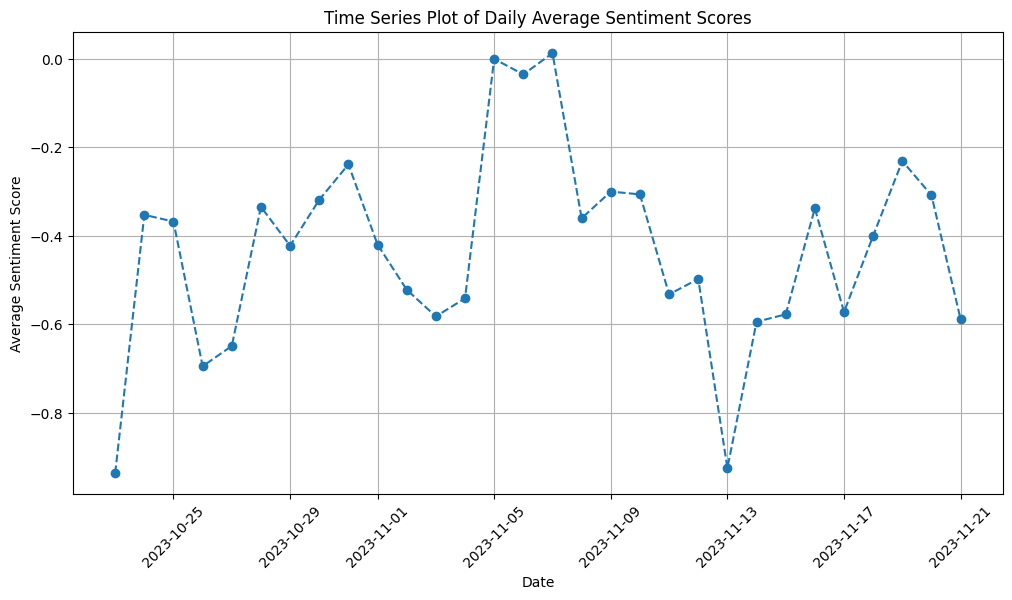

In [ ]:
import matplotlib.pyplot as plt
# Convert 'Date' back to datetime for plotting
sentiment_average['Date'] = pd.to_datetime(sentiment_average['Date'])

# Plotting the time series graph of daily average sentiment scores
plt.figure(figsize=(12, 6))
plt.plot(sentiment_average['Date'], sentiment_average['Average Sentiment Score'], marker='o', linestyle='--')
plt.title('Time Series Plot of Daily Average Sentiment Scores')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
